In [2]:
# from pycisTopic.pseudobulk_peak_calling import export_pseudobulk, peak_calling
import pyranges as pr
import requests
import os
import pandas as pd
import glob
import pickle

In [3]:
%load_ext lab_black

In [6]:
# get chromosome sizes (hg38)
if not os.path.exists("chromsizes.txt"):
    target_url = (
        "http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
    )
    chromsizes = pd.read_csv(target_url, sep="\t", header=None)
    chromsizes.columns = ["Chromosome", "End"]
    chromsizes["Start"] = [0] * chromsizes.shape[0]
    chromsizes = chromsizes.loc[:, ["Chromosome", "Start", "End"]]
    chromsizes = pr.PyRanges(chromsizes)
    chromsizes.to_csv("chromsizes.txt")
    chromsizes
else:
    chromsizes = pd.read_csv("chromsizes.txt")

In [7]:
cto_consensus_path_dict = {
    x.split("/")[-1].split(f".")[0]: x
    for x in sorted(
        glob.glob("cistopic_objects_master/cto_malefemale_celltypefair.pkl")
    )
}
cto_consensus_path_dict

{'cto_malefemale_celltypefair': 'cistopic_objects_master/cto_malefemale_celltypefair.pkl'}

In [8]:
import gc
import logging
import os
import re
import subprocess
import sys
from typing import Dict, List, Optional, Union

import numpy as np
import pandas as pd
import pyBigWig
import pyranges as pr
import ray

from pycisTopic.cistopic_class import *
from pycisTopic.utils import *


def export_pseudobulk(
    input_data: Union["CistopicObject", pd.DataFrame, Dict[str, pd.DataFrame]],
    variable: str,
    chromsizes: Union[pd.DataFrame, pr.PyRanges],
    bed_path: str,
    bigwig_path: str,
    path_to_fragments: Optional[Dict[str, str]] = None,
    sample_id_col: Optional[str] = "sample_id",
    n_cpu: Optional[int] = 1,
    normalize_bigwig: Optional[bool] = True,
    remove_duplicates: Optional[bool] = True,
    split_pattern: Optional[str] = "___",
    use_polars: Optional[bool] = True,
    **kwargs
):
    """
    Create pseudobulks as bed and bigwig from single cell fragments file given a barcode annotation.
    Parameters
    ---------
    input_data: CistopicObject or pd.DataFrame
            A :class:`CistopicObject` containing the specified `variable` as a column in :class:`CistopicObject.cell_data` or a cell metadata
            :class:`pd.DataFrame` containing barcode as rows, containing the specified `variable` as a column (additional columns are
            possible) and a `sample_id` column. Index names must contain the BARCODE (e.g. ATGTCGTC-1), additional tags are possible separating with -
            (e.g. ATGCTGTGCG-1-Sample_1). The levels in the sample_id column must agree with the keys in the path_to_fragments dictionary.
            Alternatively, if the cell metadata contains a column named barcode it will be used instead of the index names.
    variable: str
            A character string indicating the column that will be used to create the different group pseudobulk. It must be included in
            the cell metadata provided as input_data.
    chromsizes: pd.DataFrame or pr.PyRanges
            A data frame or :class:`pr.PyRanges` containing size of each chromosome, containing 'Chromosome', 'Start' and 'End' columns.
    bed_path: str
            Path to folder where the fragments bed files per group will be saved. If None, files will not be generated.
    bigwig_path: str
            Path to folder where the bigwig files per group will be saved. If None, files will not be generated.
    path_to_fragments: str or dict, optional
            A dictionary of character strings, with sample name as names indicating the path to the fragments file/s from which pseudobulk profiles have to
            be created. If a :class:`CistopicObject` is provided as input it will be ignored, but if a cell metadata :class:`pd.DataFrame` is provided it
            is necessary to provide it. The keys of the dictionary need to match with the sample_id tag added to the index names of the input data frame.
    sample_id_col: str, optional
            Name of the column containing the sample name per barcode in the input :class:`CistopicObject.cell_data` or class:`pd.DataFrame`. Default: 'sample_id'.
    n_cpu: int, optional
            Number of cores to use. Default: 1.
    normalize_bigwig: bool, optional
            Whether bigwig files should be CPM normalized. Default: True.
    remove_duplicates: bool, optional
            Whether duplicates should be removed before converting the data to bigwig.
    split_pattern: str, optional
            Pattern to split cell barcode from sample id. Default: ___ .
    use_polars: bool, optional
            Whether to use polars to read fragments files. Default: True.
    **kwargs
            Additional parameters for ray.init()
    Return
    ------
    dict
            A dictionary containing the paths to the newly created bed fragments files per group a dictionary containing the paths to the
            newly created bigwig files per group.
    """
    # Create logger
    level = logging.INFO
    log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
    handlers = [logging.StreamHandler(stream=sys.stdout)]
    logging.basicConfig(level=level, format=log_format, handlers=handlers)
    log = logging.getLogger("cisTopic")

    # Get fragments file
    if isinstance(input_data, CistopicObject):
        path_to_fragments = input_data.path_to_fragments
        if path_to_fragments is None:
            log.error("No path_to_fragments in this cisTopic object.")
        cell_data = input_data.cell_data
    elif isinstance(input_data, pd.DataFrame):
        if path_to_fragments is None:
            log.error("Please, provide path_to_fragments.")
        cell_data = input_data
    # Check for sample_id column
    try:
        sample_ids = list(set(cell_data[sample_id_col]))
    except ValueError:
        print(
            'Please, include a sample identification column (e.g. "sample_id") in your cell metadata!'
        )

    # Get fragments
    fragments_df_dict = {}
    for sample_id in path_to_fragments.keys():
        if sample_id not in sample_ids:
            log.info(
                "The following path_to_fragments entry is not found in the cell metadata sample_id_col: ",
                sample_id,
                ". It will be ignored.",
            )
        else:
            log.info("Reading fragments from " + path_to_fragments[sample_id])
            fragments_df = read_fragments_from_file(
                path_to_fragments[sample_id], use_polars=use_polars
            ).df
            # Convert to int32 for memory efficiency
            fragments_df.Start = np.int32(fragments_df.Start)
            fragments_df.End = np.int32(fragments_df.End)
            if "Score" in fragments_df:
                fragments_df.Score = np.int32(fragments_df.Score)
            if "barcode" in cell_data:
                fragments_df = fragments_df.loc[
                    fragments_df["Name"].isin(cell_data["barcode"].tolist())
                ]
            else:
                fragments_df = fragments_df.loc[
                    fragments_df["Name"].isin(
                        prepare_tag_cells(cell_data.index.tolist(), split_pattern)
                    )
                ]
            fragments_df_dict[sample_id] = fragments_df

    # Set groups
    if "barcode" in cell_data:
        cell_data = cell_data.loc[:, [variable, sample_id_col, "barcode"]]
    else:
        cell_data = cell_data.loc[:, [variable, sample_id_col]]
    cell_data[variable] = cell_data[variable].replace(" ", "", regex=True)
    cell_data[variable] = cell_data[variable].replace("[^A-Za-z0-9]+", "_", regex=True)
    groups = sorted(list(set(cell_data[variable])))
    # Check chromosome sizes
    if isinstance(chromsizes, pd.DataFrame):
        chromsizes = chromsizes.loc[:, ["Chromosome", "Start", "End"]]
        chromsizes = pr.PyRanges(chromsizes)
    # Check that output dir exist and generate output paths
    if isinstance(bed_path, str):
        if not os.path.exists(bed_path):
            os.makedirs(bed_path)
        bed_paths = {
            group: os.path.join(bed_path, str(group) + ".bed.gz") for group in groups
        }
    else:
        bed_paths = {}
    if isinstance(bigwig_path, str):
        if not os.path.exists(bigwig_path):
            os.makedirs(bigwig_path)
        bw_paths = {
            group: os.path.join(bigwig_path, str(group) + ".bw") for group in groups
        }
    else:
        bw_paths = {}
    # Create pseudobulks
    if n_cpu > 1:
        ray.init(num_cpus=n_cpu, **kwargs)
        ray_handle = ray.wait(
            [
                export_pseudobulk_ray.remote(
                    cell_data,
                    group,
                    fragments_df_dict,
                    chromsizes,
                    bigwig_path,
                    bed_path,
                    sample_id_col,
                    normalize_bigwig,
                    remove_duplicates,
                    split_pattern,
                )
                for group in groups
            ],
            num_returns=len(groups),
        )
        ray.shutdown()
    else:
        [
            export_pseudobulk_one_sample(
                cell_data,
                group,
                fragments_df_dict,
                chromsizes,
                bigwig_path,
                bed_path,
                sample_id_col,
                normalize_bigwig,
                remove_duplicates,
                split_pattern,
            )
            for group in groups
        ]

    return bw_paths, bed_paths


def export_pseudobulk_one_sample(
    cell_data: pd.DataFrame,
    group: str,
    fragments_df_dict: Dict[str, pd.DataFrame],
    chromsizes: pr.PyRanges,
    bigwig_path: str,
    bed_path: str,
    sample_id_col: Optional[str] = "sample_id",
    normalize_bigwig: Optional[bool] = True,
    remove_duplicates: Optional[bool] = True,
    split_pattern: Optional[str] = "___",
):
    """
    Create pseudobulk as bed and bigwig from single cell fragments file given a barcode annotation and a group.
    Parameters
    ---------
    cell_data: pd.DataFrame
            A cell metadata :class:`pd.Dataframe` containing barcodes, their annotation and their sample of origin.
    group: str
            A character string indicating the group for which pseudobulks will be created.
    fragments_df_dict: dict
            A dictionary containing data frames as values with 'Chromosome', 'Start', 'End', 'Name', and 'Score' as columns; and sample label
            as keys. 'Score' indicates the number of times that a fragments is found assigned to that barcode.
    chromsizes: pr.PyRanges
            A :class:`pr.PyRanges` containing size of each column, containing 'Chromosome', 'Start' and 'End' columns.
    bigwig_path: str
            Path to folder where the bigwig file will be saved.
    bed_path: str
            Path to folder where the fragments bed file will be saved.
    sample_id_col: str, optional
            Name of the column containing the sample name per barcode in the input :class:`CistopicObject.cell_data` or class:`pd.DataFrame`. Default: 'sample_id'.
    normalize_bigwig: bool, optional
            Whether bigwig files should be CPM normalized. Default: True.
    remove_duplicates: bool, optional
            Whether duplicates should be removed before converting the data to bigwig.
    split_pattern: str
            Pattern to split cell barcode from sample id. Default: ___ .
    """
    # Create logger
    level = logging.INFO
    log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
    handlers = [logging.StreamHandler(stream=sys.stdout)]
    logging.basicConfig(level=level, format=log_format, handlers=handlers)
    log = logging.getLogger("cisTopic")

    log.info("Creating pseudobulk for " + str(group))
    group_fragments_list = []
    group_fragments_dict = {}
    for sample_id in fragments_df_dict:
        sample_data = cell_data[cell_data.loc[:, sample_id_col].isin([sample_id])]
        if "barcode" in sample_data:
            sample_data.index = sample_data["barcode"].tolist()
        else:
            sample_data.index = prepare_tag_cells(
                sample_data.index.tolist(), split_pattern
            )
        group_var = sample_data.iloc[:, 0]
        barcodes = group_var[group_var.isin([group])].index.tolist()
        fragments_df = fragments_df_dict[sample_id]
        group_fragments = fragments_df.loc[fragments_df["Name"].isin(barcodes)]
        if len(fragments_df_dict) > 1:
            group_fragments_dict[sample_id] = group_fragments

    if len(fragments_df_dict) > 1:
        group_fragments_list = [
            group_fragments_dict[list(group_fragments_dict.keys())[x]]
            for x in range(len(fragments_df_dict))
        ]
        group_fragments = group_fragments_list[0].append(group_fragments_list[1:])

    group_fragments = group_fragments[
        group_fragments["Chromosome"].isin(chromsizes.Chromosome)
    ]

    del group_fragments_dict
    del group_fragments_list
    del fragments_df
    gc.collect()

    group_pr = pr.PyRanges(group_fragments)
    if isinstance(bigwig_path, str):
        bigwig_path_group = os.path.join(bigwig_path, str(group) + ".bw")
        if remove_duplicates:
            group_pr.to_bigwig(
                path=bigwig_path_group,
                chromosome_sizes=chromsizes,
                rpm=normalize_bigwig,
            )
        else:
            group_pr.to_bigwig(
                path=bigwig_path_group,
                chromosome_sizes=chromsizes,
                rpm=normalize_bigwig,
                value_col="Score",
            )
    if isinstance(bed_path, str):
        bed_path_group = os.path.join(bed_path, str(group) + ".bed.gz")
        group_pr.to_bed(
            path=bed_path_group, keep=False, compression="infer", chain=False
        )

    log.info(str(group) + " done!")


@ray.remote
def export_pseudobulk_ray(
    cell_data: pd.DataFrame,
    group: str,
    fragments_df_dict: Dict[str, pd.DataFrame],
    chromsizes: pr.PyRanges,
    bigwig_path: str,
    bed_path: str,
    sample_id_col: Optional[str] = "sample_id",
    normalize_bigwig: Optional[bool] = True,
    remove_duplicates: Optional[bool] = True,
    split_pattern: Optional[str] = "___",
):
    """
    Create pseudobulk as bed and bigwig from single cell fragments file given a barcode annotation and a group.
    Parameters
    ---------
    cell_data: pd.DataFrame
            A cell metadata :class:`pd.Dataframe` containing barcodes, their annotation and their sample of origin.
    group: str
            A character string indicating the group for which pseudobulks will be created.
    fragments_df_dict: dict
            A dictionary containing data frames as values with 'Chromosome', 'Start', 'End', 'Name', and 'Score' as columns; and sample label
            as keys. 'Score' indicates the number of times that a fragments is found assigned to that barcode.
    chromsizes: pr.PyRanges
            A :class:`pr.PyRanges` containing size of each column, containing 'Chromosome', 'Start' and 'End' columns.
    bed_path: str
            Path to folder where the fragments bed file will be saved.
    bigwig_path: str
            Path to folder where the bigwig file will be saved.
    sample_id_col: str, optional
            Name of the column containing the sample name per barcode in the input :class:`CistopicObject.cell_data` or class:`pd.DataFrame`. Default: 'sample_id'.
    normalize_bigwig: bool, optional
            Whether bigwig files should be CPM normalized. Default: True.
    remove_duplicates: bool, optional
            Whether duplicates should be removed before converting the data to bigwig.
    split_pattern: str
            Pattern to split cell barcode from sample id. Default: ___ .
    """
    export_pseudobulk_one_sample(
        cell_data,
        group,
        fragments_df_dict,
        chromsizes,
        bigwig_path,
        bed_path,
        sample_id_col,
        normalize_bigwig,
        remove_duplicates,
        split_pattern,
    )

In [9]:
sample = "cto_malefemale_celltypefair"

In [10]:
cto_path = cto_consensus_path_dict[sample]
with open(cto_path, "rb") as f:
    cto = pickle.load(f)

In [11]:
cto.cell_data

,cisTopic_log_nr_frag,cisTopic_nr_frag,cisTopic_log_nr_acc,cisTopic_nr_acc,Log_total_nr_frag,Log_unique_nr_frag,Total_nr_frag,Unique_nr_frag,Dupl_nr_frag,Dupl_rate,...,Log_unique_nr_frag_in_regions,consensus_cell_type_individual,seurat_cell_type_pred_score,cell_type__mega,seurat_cell_type_pred_score__mega,consensus_cell_type__mega,seurat_cell_type__mega,harmony_pycisTopic_leiden_10_3.0,harmony_consensus_cell_type__mega,tech_fmx_sample
CTTGTAACTTCCTGAG___VIB_10xmultiome_2.FIXEDCELLS,2.784617,609,2.774517,595,3.088490,2.856124,1226,718,508,0.414356,...,6.282267,Cytotoxic T cell,0.581713,Cytotoxic T cell,0.516572,Cytotoxic T cell,Cytotoxic T cell,8,Cytotoxic T cell,10xmultiome_sampleB
CCTAACCGACCAGGAC___CNA_10xmultiome_2.FIXEDCELLS,4.043244,11047,3.972527,9387,4.594238,4.456837,39286,28631,10655,0.271216,...,9.164192,CD14+ monocyte,0.755111,CD14+ monocyte,0.587581,CD14+ monocyte,CD14+ monocyte,21,Cytotoxic T cell,10xmultiome_sampleB
CGATTGCCTCACTTGG___CNA_10xmultiome_1.FIXEDCELLS,4.051924,11270,3.958564,9090,4.461544,4.185315,28943,15322,13621,0.470615,...,9.166075,Cytotoxic T cell,0.759118,Cytotoxic T cell,0.374029,Cytotoxic T cell,Cytotoxic T cell,8,Cytotoxic T cell,10xmultiome_sampleB
GACTAGGCTGCCACAC___CNA_10xmultiome_2.FIXEDCELLS,3.751587,5644,3.689131,4888,3.988425,3.831614,9737,6786,2951,0.303071,...,8.427050,Cytotoxic T cell,0.549625,Cytotoxic T cell,0.538963,Natural killer cell,Cytotoxic T cell,17,Cytotoxic T cell,10xmultiome_sampleB
GGCTAAGCTTGATGTT___VIB_10xmultiome_1.FIXEDCELLS,3.65782,4548,3.596817,3952,3.920436,3.720077,8326,5249,3077,0.369565,...,8.303257,Natural killer cell,0.555911,Natural killer cell,0.503232,Natural killer cell,Natural killer cell,17,Cytotoxic T cell,10xmultiome_sampleB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AACCTTTGTGCTGAAG___VIB_10xv1_1.FIXEDCELLS,4.031408,10750,3.975156,9444,4.280738,4.159898,19087,14451,4636,0.242888,...,9.231710,CD14+ monocyte,0.497591,CD14+ monocyte,0.428762,Dendritic cell,CD14+ monocyte,28,Dendritic cell,10xv1_sampleB
TGAGCCGGTTTGACCA___VIB_10xv1_2.FIXEDCELLS,4.034749,10833,3.980912,9570,4.289634,4.211388,19482,16270,3212,0.164870,...,9.048997,Dendritic cell,0.614861,Dendritic cell,0.769490,Dendritic cell,Dendritic cell,28,Dendritic cell,10xv1_sampleB
GACTAACGTAACATAG___VIB_10xv1_2.FIXEDCELLS,3.884739,7669,3.842172,6953,4.156761,4.071587,14347,11792,2555,0.178086,...,8.752740,CD14+ monocyte,0.660317,CD14+ monocyte,0.488022,Dendritic cell,CD14+ monocyte,28,Dendritic cell,10xv1_sampleB
TACGGATCATCACAGT___VIB_10xv1_1.FIXEDCELLS,4.411973,25821,4.288495,19431,4.708183,4.510143,51072,32370,18702,0.366189,...,10.014671,CD14+ monocyte,0.604183,Dendritic cell,0.775639,Dendritic cell,Dendritic cell,28,Dendritic cell,10xv1_sampleB


In [12]:
cto.cell_data["barcode"]

CTTGTAACTTCCTGAG___VIB_10xmultiome_2.FIXEDCELLS    CTTGTAACTTCCTGAG
CCTAACCGACCAGGAC___CNA_10xmultiome_2.FIXEDCELLS    CCTAACCGACCAGGAC
CGATTGCCTCACTTGG___CNA_10xmultiome_1.FIXEDCELLS    CGATTGCCTCACTTGG
GACTAGGCTGCCACAC___CNA_10xmultiome_2.FIXEDCELLS    GACTAGGCTGCCACAC
GGCTAAGCTTGATGTT___VIB_10xmultiome_1.FIXEDCELLS    GGCTAAGCTTGATGTT
                                                         ...       
AACCTTTGTGCTGAAG___VIB_10xv1_1.FIXEDCELLS          AACCTTTGTGCTGAAG
TGAGCCGGTTTGACCA___VIB_10xv1_2.FIXEDCELLS          TGAGCCGGTTTGACCA
GACTAACGTAACATAG___VIB_10xv1_2.FIXEDCELLS          GACTAACGTAACATAG
TACGGATCATCACAGT___VIB_10xv1_1.FIXEDCELLS          TACGGATCATCACAGT
CTAGGATGTAAACGGC___VIB_10xv1_2.FIXEDCELLS          CTAGGATGTAAACGGC
Name: barcode, Length: 60487, dtype: object

In [13]:
with pd.option_context(
    "display.max_rows",
    None,
    "display.max_columns",
    None,
    "display.precision",
    3,
):
    print(
        cto.cell_data.groupby(["harmony_consensus_cell_type__mega"])[
            "tech_fmx_sample"
        ].value_counts()
    )

harmony_consensus_cell_type__mega  tech_fmx_sample    
B cell                             10xmultiome_sampleA     442
                                   10xmultiome_sampleB     442
                                   10xv11_sampleA          442
                                   10xv11_sampleB          442
                                   10xv1_sampleA           442
                                   10xv1_sampleB           442
                                   10xv2_sampleA           442
                                   10xv2_sampleB           442
                                   ddseq_sampleA           442
                                   ddseq_sampleB           442
                                   hydrop_sampleA          442
                                   hydrop_sampleB          442
                                   mtscatac_sampleA        442
                                   mtscatac_sampleB        442
                                   s3atac_sampleA          254


In [19]:
cto.cell_data["tech_fmx_sample__harmony_consensus_cell_type__mega"] = (
    cto.cell_data["tech_fmx_sample"]
    + "__"
    + cto.cell_data["harmony_consensus_cell_type__mega"]
)

In [ ]:
# for sample in ["BRO_mtscatac_1.LIBDS"]:
bw_paths_dict = {}
bed_paths_dict = {}

import ray

if ray.is_initialized():
    print("Shutting down Ray")
    ray.shutdown()

for sample in cto_consensus_path_dict.keys():
    # for sample in ["BRO_mtscatac_1.LIBDS"]:
    bed_path = os.path.join(
        "male_female_coverage", f"{sample}__SCREEN_pseudobulk_bed_files"
    )
    bw_path = os.path.join(
        "male_female_coverage", f"{sample}__SCREEN_pseudobulk_bw_files"
    )
    if not os.path.exists(bed_path):
        # cto_path = cto_consensus_path_dict[sample]
        # with open(cto_path, "rb") as f:
        #     cto = pickle.load(f)

        bw_paths, bed_paths = export_pseudobulk(
            input_data=cto,
            variable="tech_fmx_sample__harmony_consensus_cell_type__mega",
            sample_id_col="sample_id",
            chromsizes=chromsizes,
            bed_path=bed_path,
            bigwig_path=bw_path,
            path_to_fragments=fragments_path_dict,
            n_cpu=72,
            normalize_bigwig=False,
            remove_duplicates=True,
        )

        if ray.is_initialized():
            print("Shutting down Ray")
            ray.shutdown()
    else:
        print(f"{bed_path} exists, skipping...")

2023-03-06 18:36:34,399 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/SAN_10xmultiome_2.FIXEDCELLS.fragments.tsv.gz


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 18:38:15,337 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/OHS_s3atac_1.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:39:23,026 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_10xv11_5.FIXEDCELLS.fragments.tsv.gz


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 18:39:42,566 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/STA_10xv11_1.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:40:03,329 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_hydrop_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:40:32,851 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_10xv2_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:41:54,432 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/VIB_hydrop_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:42:28,325 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/STA_10xv11_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:42:58,903 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/VIB_10xmultiome_1.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:43:19,584 cisTopic     INFO     Reading fragments from ../1_data_repos

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 18:46:40,698 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_10xv11_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:47:24,088 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_10xmultiome_2.FIXEDCELLS.fragments.tsv.gz


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 18:48:25,733 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/VIB_10xmultiome_2.FIXEDCELLS.fragments.tsv.gz


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 18:48:58,743 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/VIB_10xv2_2.FIXEDCELLS.fragments.tsv.gz


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 18:49:54,651 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_10xv11_4.FIXEDCELLS.fragments.tsv.gz


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 18:50:08,702 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/MDC_mtscatac_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:51:37,740 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_hydrop_3.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:52:03,568 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/BRO_mtscatac_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:52:52,693 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/BRO_mtscatac_1.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:53:45,833 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_10xmultiome_1.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:54:39,103 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/VIB_10xv1_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 18:57:48,158 cisTopic     INFO     Reading fragments from ../1_data

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 19:03:00,273 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_mtscatac_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 19:03:22,911 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/SAN_10xmultiome_1.FIXEDCELLS.fragments.tsv.gz


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/venv/bin/ipython", line 8, in <module>
    sys.exit(start_ipython())
  File "/opt/venv/lib/python3.8/site-packages/IPython/__init__.py", line 124, in start_ipython
    return launch_new_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.8/site-packages/IPython/terminal/ipapp.py", line 314,

2023-03-06 19:04:43,260 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/HAR_ddseq_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 19:06:20,938 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/CNA_10xv2_1.FIXEDCELLS.fragments.tsv.gz
2023-03-06 19:07:17,817 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/EPF_hydrop_2.FIXEDCELLS.fragments.tsv.gz
2023-03-06 19:07:43,511 cisTopic     INFO     Reading fragments from ../1_data_repository/fixedcells_fragments/MDC_mtscatac_1.FIXEDCELLS.fragments.tsv.gz


2023-03-06 19:10:05,710	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(export_pseudobulk_ray pid=3625796) 2023-03-06 19:10:25,016 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleA_Bcell


(export_pseudobulk_ray pid=3625796) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625762) 2023-03-06 19:10:37,597 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleA_CD14_monocyte


(export_pseudobulk_ray pid=3625762) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 19:10:48,954 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleA_CD16_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:11:00,373 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleA_CD4_Tcell
(export_pseudobulk_ray pid=3625800) 2023-03-06 19:11:07,734 cisTopic     INFO     10xmultiome_sampleA_CD16_monocyte done!


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 19:11:11,163 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleA_CytotoxicTcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:11:24,500 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleA_Dendriticcell
(export_pseudobulk_ray pid=3625796) 2023-03-06 19:11:30,707 cisTopic     INFO     10xmultiome_sampleA_Bcell done!


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625796) 2023-03-06 19:11:35,838 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleA_Naturalkillercell


(export_pseudobulk_ray pid=3625796) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:11:46,881 cisTopic     INFO     10xmultiome_sampleA_Dendriticcell done!
(export_pseudobulk_ray pid=3625780) 2023-03-06 19:11:48,882 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleB_Bcell


(export_pseudobulk_ray pid=3625780) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:12:00,803 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleB_CD14_monocyte


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625786) 2023-03-06 19:12:15,024 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleB_CD16_monocyte


(raylet) Spilled 17811 MiB, 2 objects, write throughput 830 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


(export_pseudobulk_ray pid=3625796) 2023-03-06 19:12:19,630 cisTopic     INFO     10xmultiome_sampleA_Naturalkillercell done!


(export_pseudobulk_ray pid=3625786) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(raylet) Spilled 35623 MiB, 4 objects, write throughput 1045 MiB/s.


(export_pseudobulk_ray pid=3625786) 2023-03-06 19:12:34,511 cisTopic     INFO     10xmultiome_sampleB_CD16_monocyte done!
(export_pseudobulk_ray pid=3625780) 2023-03-06 19:13:02,002 cisTopic     INFO     10xmultiome_sampleB_Bcell done!
(export_pseudobulk_ray pid=3625762) 2023-03-06 19:13:09,026 cisTopic     INFO     10xmultiome_sampleA_CD14_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 19:13:23,684 cisTopic     INFO     10xmultiome_sampleA_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:14:02,991 cisTopic     INFO     10xmultiome_sampleA_CD4_Tcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:14:45,860 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleB_CD4_Tcell
(export_pseudobulk_ray pid=3625797) 2023-03-06 19:14:46,256 cisTopic     INFO     10xmultiome_sampleB_CD14_monocyte done!


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(raylet) Spilled 53434 MiB, 6 objects, write throughput 915 MiB/s.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:17:20,726 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleB_CytotoxicTcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(raylet) Spilled 71246 MiB, 8 objects, write throughput 855 MiB/s.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:18:02,449 cisTopic     INFO     10xmultiome_sampleB_CD4_Tcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:19:58,429 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleB_Dendriticcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(raylet) Spilled 89058 MiB, 10 objects, write throughput 825 MiB/s.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:20:23,336 cisTopic     INFO     10xmultiome_sampleB_Dendriticcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 19:21:01,421 cisTopic     INFO     10xmultiome_sampleB_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 19:22:30,294 cisTopic     INFO     Creating pseudobulk for 10xmultiome_sampleB_Naturalkillercell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(raylet) Spilled 106869 MiB, 12 objects, write throughput 810 MiB/s.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:23:13,243 cisTopic     INFO     10xmultiome_sampleB_Naturalkillercell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 19:25:05,913 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleA_Bcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:26:19,242 cisTopic     INFO     10xv11_sampleA_Bcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 19:27:38,515 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleA_CD14_monocyte


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(raylet) Spilled 142493 MiB, 16 objects, write throughput 790 MiB/s.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:29:53,470 cisTopic     INFO     10xv11_sampleA_CD14_monocyte done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 19:30:15,977 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleA_CD16_monocyte


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:30:36,575 cisTopic     INFO     10xv11_sampleA_CD16_monocyte done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 19:32:51,329 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleA_CD4_Tcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:35:26,903 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleA_CytotoxicTcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:36:25,031 cisTopic     INFO     10xv11_sampleA_CD4_Tcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:37:39,414 cisTopic     INFO     10xv11_sampleA_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:37:59,404 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleA_Dendriticcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:38:25,413 cisTopic     INFO     10xv11_sampleA_Dendriticcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:40:35,684 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleA_Naturalkillercell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:41:17,610 cisTopic     INFO     10xv11_sampleA_Naturalkillercell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:43:09,569 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleB_Bcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:44:32,688 cisTopic     INFO     10xv11_sampleB_Bcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:45:49,335 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleB_CD14_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(raylet) Spilled 267174 MiB, 30 objects, write throughput 752 MiB/s.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:48:00,078 cisTopic     INFO     10xv11_sampleB_CD14_monocyte done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:48:27,952 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleB_CD16_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:48:49,143 cisTopic     INFO     10xv11_sampleB_CD16_monocyte done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:51:04,725 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleB_CD4_Tcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:53:42,058 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleB_CytotoxicTcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:55:12,506 cisTopic     INFO     10xv11_sampleB_CD4_Tcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:56:16,284 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleB_Dendriticcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 19:56:36,864 cisTopic     INFO     10xv11_sampleB_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:56:40,603 cisTopic     INFO     10xv11_sampleB_Dendriticcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 19:58:50,098 cisTopic     INFO     Creating pseudobulk for 10xv11_sampleB_Naturalkillercell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 19:59:42,152 cisTopic     INFO     10xv11_sampleB_Naturalkillercell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 20:01:25,154 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleA_Bcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:02:43,969 cisTopic     INFO     10xv1_sampleA_Bcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 20:03:58,681 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleA_CD14_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:06:21,752 cisTopic     INFO     10xv1_sampleA_CD14_monocyte done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 20:06:38,094 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleA_CD16_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:07:00,752 cisTopic     INFO     10xv1_sampleA_CD16_monocyte done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 20:09:20,020 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleA_CD4_Tcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:11:55,699 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleA_CytotoxicTcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:12:38,320 cisTopic     INFO     10xv1_sampleA_CD4_Tcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:14:09,313 cisTopic     INFO     10xv1_sampleA_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:14:28,384 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleA_Dendriticcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:14:54,674 cisTopic     INFO     10xv1_sampleA_Dendriticcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:17:07,018 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleA_Naturalkillercell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:17:54,086 cisTopic     INFO     10xv1_sampleA_Naturalkillercell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:19:45,722 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleB_Bcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:21:22,799 cisTopic     INFO     10xv1_sampleB_Bcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:22:30,346 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleB_CD14_monocyte


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:25:12,262 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleB_CD16_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:25:36,543 cisTopic     INFO     10xv1_sampleB_CD16_monocyte done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:25:37,624 cisTopic     INFO     10xv1_sampleB_CD14_monocyte done!


(raylet) Spilled 534348 MiB, 60 objects, write throughput 714 MiB/s.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:27:54,563 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleB_CD4_Tcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:30:29,613 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleB_CytotoxicTcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:32:25,140 cisTopic     INFO     10xv1_sampleB_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:32:51,126 cisTopic     INFO     10xv1_sampleB_CD4_Tcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:33:09,254 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleB_Dendriticcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:33:40,405 cisTopic     INFO     10xv1_sampleB_Dendriticcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:35:45,410 cisTopic     INFO     Creating pseudobulk for 10xv1_sampleB_Naturalkillercell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:36:40,321 cisTopic     INFO     10xv1_sampleB_Naturalkillercell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:38:28,787 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleA_Bcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:40:14,091 cisTopic     INFO     10xv2_sampleA_Bcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:41:05,129 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleA_CD14_monocyte


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:43:53,685 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleA_CD16_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:44:17,180 cisTopic     INFO     10xv2_sampleA_CD16_monocyte done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:45:44,277 cisTopic     INFO     10xv2_sampleA_CD14_monocyte done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 20:46:39,245 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleA_CD4_Tcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 20:49:23,015 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleA_CytotoxicTcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 20:51:59,327 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleA_Dendriticcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 20:52:10,775 cisTopic     INFO     10xv2_sampleA_CD4_Tcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 20:52:11,414 cisTopic     INFO     10xv2_sampleA_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 20:52:30,200 cisTopic     INFO     10xv2_sampleA_Dendriticcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 20:54:38,129 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleA_Naturalkillercell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 20:55:37,974 cisTopic     INFO     10xv2_sampleA_Naturalkillercell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 20:57:16,315 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleB_Bcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 20:59:06,699 cisTopic     INFO     10xv2_sampleB_Bcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 20:59:58,075 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleB_CD14_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 21:02:46,082 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleB_CD16_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 21:03:12,905 cisTopic     INFO     10xv2_sampleB_CD16_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:04:36,758 cisTopic     INFO     10xv2_sampleB_CD14_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:05:18,878 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleB_CD4_Tcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 21:07:57,163 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleB_CytotoxicTcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 21:10:37,977 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleB_Dendriticcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 21:10:50,028 cisTopic     INFO     10xv2_sampleB_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:10:58,013 cisTopic     INFO     10xv2_sampleB_CD4_Tcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 21:11:11,438 cisTopic     INFO     10xv2_sampleB_Dendriticcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 21:13:16,768 cisTopic     INFO     Creating pseudobulk for 10xv2_sampleB_Naturalkillercell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 21:14:21,278 cisTopic     INFO     10xv2_sampleB_Naturalkillercell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 21:15:55,585 cisTopic     INFO     Creating pseudobulk for ddseq_sampleA_Bcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 21:17:27,579 cisTopic     INFO     ddseq_sampleA_Bcell done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 21:18:36,735 cisTopic     INFO     Creating pseudobulk for ddseq_sampleA_CD14_monocyte


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 21:21:04,422 cisTopic     INFO     ddseq_sampleA_CD14_monocyte done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 21:21:13,574 cisTopic     INFO     Creating pseudobulk for ddseq_sampleA_CD16_monocyte


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 21:21:36,466 cisTopic     INFO     ddseq_sampleA_CD16_monocyte done!
(export_pseudobulk_ray pid=3625797) 2023-03-06 21:23:52,290 cisTopic     INFO     Creating pseudobulk for ddseq_sampleA_CD4_Tcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:26:41,880 cisTopic     INFO     Creating pseudobulk for ddseq_sampleA_CytotoxicTcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:29:19,827 cisTopic     INFO     ddseq_sampleA_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:29:27,218 cisTopic     INFO     Creating pseudobulk for ddseq_sampleA_Dendriticcell
(export_pseudobulk_ray pid=3625797) 2023-03-06 21:29:33,878 cisTopic     INFO     ddseq_sampleA_CD4_Tcell done!


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:29:51,988 cisTopic     INFO     ddseq_sampleA_Dendriticcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:32:06,637 cisTopic     INFO     Creating pseudobulk for ddseq_sampleA_Naturalkillercell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:32:24,168 cisTopic     INFO     ddseq_sampleA_Naturalkillercell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:34:42,046 cisTopic     INFO     Creating pseudobulk for ddseq_sampleB_Bcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:36:15,674 cisTopic     INFO     ddseq_sampleB_Bcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:37:20,036 cisTopic     INFO     Creating pseudobulk for ddseq_sampleB_CD14_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:39:56,308 cisTopic     INFO     ddseq_sampleB_CD14_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:40:05,032 cisTopic     INFO     Creating pseudobulk for ddseq_sampleB_CD16_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:40:31,096 cisTopic     INFO     ddseq_sampleB_CD16_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:42:40,515 cisTopic     INFO     Creating pseudobulk for ddseq_sampleB_CD4_Tcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(raylet) Spilled 1050885 MiB, 118 objects, write throughput 696 MiB/s.


(export_pseudobulk_ray pid=3625797) 2023-03-06 21:45:26,628 cisTopic     INFO     Creating pseudobulk for ddseq_sampleB_CytotoxicTcell


(export_pseudobulk_ray pid=3625797) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 21:47:58,282 cisTopic     INFO     Creating pseudobulk for ddseq_sampleB_Dendriticcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625797) 2023-03-06 21:48:09,341 cisTopic     INFO     ddseq_sampleB_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 21:48:15,801 cisTopic     INFO     ddseq_sampleB_Dendriticcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:48:24,300 cisTopic     INFO     ddseq_sampleB_CD4_Tcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:50:37,876 cisTopic     INFO     Creating pseudobulk for ddseq_sampleB_Naturalkillercell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:50:54,926 cisTopic     INFO     ddseq_sampleB_Naturalkillercell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:53:14,773 cisTopic     INFO     Creating pseudobulk for hydrop_sampleA_Bcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:53:49,515 cisTopic     INFO     hydrop_sampleA_Bcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:55:58,894 cisTopic     INFO     Creating pseudobulk for hydrop_sampleA_CD14_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:57:22,519 cisTopic     INFO     hydrop_sampleA_CD14_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 21:58:45,848 cisTopic     INFO     Creating pseudobulk for hydrop_sampleA_CD16_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 21:59:01,390 cisTopic     INFO     hydrop_sampleA_CD16_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:01:22,213 cisTopic     INFO     Creating pseudobulk for hydrop_sampleA_CD4_Tcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:03:00,110 cisTopic     INFO     hydrop_sampleA_CD4_Tcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:04:03,940 cisTopic     INFO     Creating pseudobulk for hydrop_sampleA_CytotoxicTcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:04:45,883 cisTopic     INFO     hydrop_sampleA_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:06:48,705 cisTopic     INFO     Creating pseudobulk for hydrop_sampleA_Dendriticcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:07:05,565 cisTopic     INFO     hydrop_sampleA_Dendriticcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:10:09,547 cisTopic     INFO     Creating pseudobulk for hydrop_sampleA_Naturalkillercell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:10:31,091 cisTopic     INFO     hydrop_sampleA_Naturalkillercell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:12:52,157 cisTopic     INFO     Creating pseudobulk for hydrop_sampleB_Bcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:13:25,834 cisTopic     INFO     hydrop_sampleB_Bcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:15:33,650 cisTopic     INFO     Creating pseudobulk for hydrop_sampleB_CD14_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:16:58,107 cisTopic     INFO     hydrop_sampleB_CD14_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:18:17,198 cisTopic     INFO     Creating pseudobulk for hydrop_sampleB_CD16_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:18:32,296 cisTopic     INFO     hydrop_sampleB_CD16_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:20:58,590 cisTopic     INFO     Creating pseudobulk for hydrop_sampleB_CD4_Tcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:22:35,873 cisTopic     INFO     hydrop_sampleB_CD4_Tcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:23:40,415 cisTopic     INFO     Creating pseudobulk for hydrop_sampleB_CytotoxicTcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:24:29,713 cisTopic     INFO     hydrop_sampleB_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:26:15,731 cisTopic     INFO     Creating pseudobulk for hydrop_sampleB_Dendriticcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:26:32,848 cisTopic     INFO     hydrop_sampleB_Dendriticcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:28:52,632 cisTopic     INFO     Creating pseudobulk for hydrop_sampleB_Naturalkillercell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:29:14,739 cisTopic     INFO     hydrop_sampleB_Naturalkillercell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:31:37,006 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleA_Bcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:33:32,453 cisTopic     INFO     mtscatac_sampleA_Bcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:34:12,545 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleA_CD14_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 22:37:02,087 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleA_CD16_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 22:37:26,424 cisTopic     INFO     mtscatac_sampleA_CD16_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:38:59,278 cisTopic     INFO     mtscatac_sampleA_CD14_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:39:42,338 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleA_CD4_Tcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 22:42:16,916 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleA_CytotoxicTcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:44:11,022 cisTopic     INFO     mtscatac_sampleA_CD4_Tcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 22:44:38,927 cisTopic     INFO     mtscatac_sampleA_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 22:44:53,178 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleA_Dendriticcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 22:45:24,965 cisTopic     INFO     mtscatac_sampleA_Dendriticcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 22:47:34,362 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleA_Naturalkillercell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 22:48:27,393 cisTopic     INFO     mtscatac_sampleA_Naturalkillercell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 22:50:13,772 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleB_Bcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 22:52:04,433 cisTopic     INFO     mtscatac_sampleB_Bcell done!
(export_pseudobulk_ray pid=3625804) 2023-03-06 22:52:57,061 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleB_CD14_monocyte


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:55:37,558 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleB_CD16_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 22:56:06,315 cisTopic     INFO     mtscatac_sampleB_CD16_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 22:58:17,658 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleB_CD4_Tcell
(export_pseudobulk_ray pid=3625804) 2023-03-06 22:58:23,473 cisTopic     INFO     mtscatac_sampleB_CD14_monocyte done!


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625804) 2023-03-06 23:00:56,721 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleB_CytotoxicTcell


(export_pseudobulk_ray pid=3625804) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:03:07,982 cisTopic     INFO     mtscatac_sampleB_CD4_Tcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:03:39,991 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleB_Dendriticcell
(export_pseudobulk_ray pid=3625804) 2023-03-06 23:03:48,058 cisTopic     INFO     mtscatac_sampleB_CytotoxicTcell done!


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:04:13,837 cisTopic     INFO     mtscatac_sampleB_Dendriticcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:06:27,726 cisTopic     INFO     Creating pseudobulk for mtscatac_sampleB_Naturalkillercell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:07:19,873 cisTopic     INFO     mtscatac_sampleB_Naturalkillercell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:09:13,058 cisTopic     INFO     Creating pseudobulk for s3atac_sampleA_Bcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:10:01,333 cisTopic     INFO     s3atac_sampleA_Bcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:11:54,843 cisTopic     INFO     Creating pseudobulk for s3atac_sampleA_CD14_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:13:23,505 cisTopic     INFO     s3atac_sampleA_CD14_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:14:39,694 cisTopic     INFO     Creating pseudobulk for s3atac_sampleA_CD16_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:15:03,034 cisTopic     INFO     s3atac_sampleA_CD16_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:17:30,492 cisTopic     INFO     Creating pseudobulk for s3atac_sampleA_CD4_Tcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:18:00,893 cisTopic     INFO     s3atac_sampleA_CD4_Tcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:20:14,908 cisTopic     INFO     Creating pseudobulk for s3atac_sampleA_CytotoxicTcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:22:12,075 cisTopic     INFO     s3atac_sampleA_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:22:53,873 cisTopic     INFO     Creating pseudobulk for s3atac_sampleA_Dendriticcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:23:15,312 cisTopic     INFO     s3atac_sampleA_Dendriticcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:25:37,795 cisTopic     INFO     Creating pseudobulk for s3atac_sampleA_Naturalkillercell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:26:13,343 cisTopic     INFO     s3atac_sampleA_Naturalkillercell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:28:18,101 cisTopic     INFO     Creating pseudobulk for s3atac_sampleB_Bcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:28:56,124 cisTopic     INFO     s3atac_sampleB_Bcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:31:01,753 cisTopic     INFO     Creating pseudobulk for s3atac_sampleB_CD14_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:32:40,912 cisTopic     INFO     s3atac_sampleB_CD14_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:33:45,907 cisTopic     INFO     Creating pseudobulk for s3atac_sampleB_CD16_monocyte


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:34:05,573 cisTopic     INFO     s3atac_sampleB_CD16_monocyte done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:36:21,743 cisTopic     INFO     Creating pseudobulk for s3atac_sampleB_CD4_Tcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:36:54,599 cisTopic     INFO     s3atac_sampleB_CD4_Tcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:39:00,910 cisTopic     INFO     Creating pseudobulk for s3atac_sampleB_CytotoxicTcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:40:25,545 cisTopic     INFO     s3atac_sampleB_CytotoxicTcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:41:43,338 cisTopic     INFO     Creating pseudobulk for s3atac_sampleB_Dendriticcell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(export_pseudobulk_ray pid=3625800) 2023-03-06 23:42:28,966 cisTopic     INFO     s3atac_sampleB_Dendriticcell done!
(export_pseudobulk_ray pid=3625800) 2023-03-06 23:45:23,065 cisTopic     INFO     Creating pseudobulk for s3atac_sampleB_Naturalkillercell


(export_pseudobulk_ray pid=3625800) /tmp/ipykernel_3615626/2558041373.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


# Plot

In [4]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pyBigWig
import seaborn as sns
from pybedtools import BedTool
import re

import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [7]:
import pybedtools

In [8]:
pybedtools.__version__

'0.8.1'

In [47]:
merged_dar_path_dict = {
    x.split("/")[-1].split("__")[1].split("_VS")[0]: x
    for x in glob.glob(
        "downstream_analysis_male_female_countfair/DARs/*Cytotoxic_T_cell*fc.bed"
    )
}
merged_dar_path_dict

{'hydrop_sampleB_Cytotoxic_T_cell': 'downstream_analysis_male_female_countfair/DARs/merged_male_female_cellcountfair__hydrop_sampleB_Cytotoxic_T_cell_VS_hydrop_sampleA_Cytotoxic_T_cell__DARs_1-0xfc.bed',
 's3atac_sampleB_Cytotoxic_T_cell': 'downstream_analysis_male_female_countfair/DARs/merged_male_female_cellcountfair__s3atac_sampleB_Cytotoxic_T_cell_VS_s3atac_sampleA_Cytotoxic_T_cell__DARs_1-0xfc.bed',
 '10xv2_sampleB_Cytotoxic_T_cell': 'downstream_analysis_male_female_countfair/DARs/merged_male_female_cellcountfair__10xv2_sampleB_Cytotoxic_T_cell_VS_10xv2_sampleA_Cytotoxic_T_cell__DARs_1-0xfc.bed',
 'mtscatac_sampleA_Cytotoxic_T_cell': 'downstream_analysis_male_female_countfair/DARs/merged_male_female_cellcountfair__mtscatac_sampleA_Cytotoxic_T_cell_VS_mtscatac_sampleB_Cytotoxic_T_cell__DARs_1-0xfc.bed',
 's3atac_sampleA_Cytotoxic_T_cell': 'downstream_analysis_male_female_countfair/DARs/merged_male_female_cellcountfair__s3atac_sampleA_Cytotoxic_T_cell_VS_s3atac_sampleB_Cytotoxic_T_c

In [48]:
regions_dict = OrderedDict({})
regions_maxstr_dict = {}
for supersample, path in merged_dar_path_dict.items():
    print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1]
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']}-{df.iloc[0]['end']}"
    regions_dict[cell_type] = region
    regions_maxstr_dict[cell_type] = df.iloc[0]["log2fc"]

regions_dict

hydrop_sampleB_Cytotoxic_T_cell
s3atac_sampleB_Cytotoxic_T_cell
10xv2_sampleB_Cytotoxic_T_cell
mtscatac_sampleA_Cytotoxic_T_cell
s3atac_sampleA_Cytotoxic_T_cell
ddseq_sampleA_Cytotoxic_T_cell
10xmultiome_sampleA_Cytotoxic_T_cell
10xv2_sampleA_Cytotoxic_T_cell
10xv1_sampleB_Cytotoxic_T_cell
10xv1_sampleA_Cytotoxic_T_cell
10xmultiome_sampleB_Cytotoxic_T_cell
ddseq_sampleB_Cytotoxic_T_cell
10xv11_sampleA_Cytotoxic_T_cell
mtscatac_sampleB_Cytotoxic_T_cell
hydrop_sampleA_Cytotoxic_T_cell
10xv11_sampleB_Cytotoxic_T_cell


OrderedDict([('hydrop_sampleB_Cytotoxic_T_cell',
              'chr14_GL000225v1_random:133488-133988'),
             ('s3atac_sampleB_Cytotoxic_T_cell', 'chr5:158234412-158234912'),
             ('10xv2_sampleB_Cytotoxic_T_cell', 'chr20:16158577-16159077'),
             ('mtscatac_sampleA_Cytotoxic_T_cell', 'chr8:47644134-47644634'),
             ('s3atac_sampleA_Cytotoxic_T_cell', 'chr5:155767413-155767913'),
             ('ddseq_sampleA_Cytotoxic_T_cell', 'chr9:104780066-104780566'),
             ('10xmultiome_sampleA_Cytotoxic_T_cell',
              'chr6:45584034-45584534'),
             ('10xv2_sampleA_Cytotoxic_T_cell', 'chr7:102408438-102408938'),
             ('10xv1_sampleB_Cytotoxic_T_cell', 'chr5:135246846-135247346'),
             ('10xv1_sampleA_Cytotoxic_T_cell', 'chr8:47644134-47644634'),
             ('10xmultiome_sampleB_Cytotoxic_T_cell',
              'chr12:124664587-124665087'),
             ('ddseq_sampleB_Cytotoxic_T_cell', 'chr2:238003558-238004058'),
         

In [49]:
regions_maxstr_dict

{'hydrop_sampleB_Cytotoxic_T_cell': 0.9843927099531742,
 's3atac_sampleB_Cytotoxic_T_cell': 0.6487396903079914,
 '10xv2_sampleB_Cytotoxic_T_cell': 1.814721837658971,
 'mtscatac_sampleA_Cytotoxic_T_cell': 0.8400013306157175,
 's3atac_sampleA_Cytotoxic_T_cell': 0.8902853527602216,
 'ddseq_sampleA_Cytotoxic_T_cell': 2.855163762621557,
 '10xmultiome_sampleA_Cytotoxic_T_cell': 0.7467226122848554,
 '10xv2_sampleA_Cytotoxic_T_cell': 0.7943653074414415,
 '10xv1_sampleB_Cytotoxic_T_cell': 2.2134068579806008,
 '10xv1_sampleA_Cytotoxic_T_cell': 0.8152837713690407,
 '10xmultiome_sampleB_Cytotoxic_T_cell': 1.3906592169707173,
 'ddseq_sampleB_Cytotoxic_T_cell': 1.1098011738501738,
 '10xv11_sampleA_Cytotoxic_T_cell': 0.7635289003973285,
 'mtscatac_sampleB_Cytotoxic_T_cell': 0.8979345101622968,
 'hydrop_sampleA_Cytotoxic_T_cell': 0.9492210488928268,
 '10xv11_sampleB_Cytotoxic_T_cell': 1.489580484219768}

In [51]:
# use --> ddseq_sampleA_Cytotoxic_T_cell and 10xv1_sampleB_Cytotoxic_T_cell

In [52]:
tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

tech_order = [
    "10xv1",
    "10xv11",
    "10xv2",
    "10xmultiome",
    "mtscatac",
    "ddseq",
    "s3atac",
    "hydrop",
]

tech_alias_dict = {
    "10xmultiome": "10x Multiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv2": "10x v2",
    "ddseq": "ddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "s3atac": "s3-ATAC",
}

cell_type_order = [
    "B_cell",
    "CD14_monocyte",
    "CD4_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16_monocyte",
]

cell_type_alias_dict = {
    "B_cell": "B cells",
    "CD14_monocyte": "CD14+\nmonocytes",
    "CD4_T_cell": "CD4+\nT cells",
    "Cytotoxic_T_cell": "CD8+\nT cells",
    "Dendritic_cell": "Dendritic\ncells",
    "Natural_killer_cell": "NK cells",
    "CD16_monocyte": "CD16+\nmonocytes",
}

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14_monocyte": "#CC6677",
    "CD4_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16_monocyte": "#44AA99",
}

# Select regions

In [53]:
regions_dict

OrderedDict([('hydrop_sampleB_Cytotoxic_T_cell',
              'chr14_GL000225v1_random:133488-133988'),
             ('s3atac_sampleB_Cytotoxic_T_cell', 'chr5:158234412-158234912'),
             ('10xv2_sampleB_Cytotoxic_T_cell', 'chr20:16158577-16159077'),
             ('mtscatac_sampleA_Cytotoxic_T_cell', 'chr8:47644134-47644634'),
             ('s3atac_sampleA_Cytotoxic_T_cell', 'chr5:155767413-155767913'),
             ('ddseq_sampleA_Cytotoxic_T_cell', 'chr9:104780066-104780566'),
             ('10xmultiome_sampleA_Cytotoxic_T_cell',
              'chr6:45584034-45584534'),
             ('10xv2_sampleA_Cytotoxic_T_cell', 'chr7:102408438-102408938'),
             ('10xv1_sampleB_Cytotoxic_T_cell', 'chr5:135246846-135247346'),
             ('10xv1_sampleA_Cytotoxic_T_cell', 'chr8:47644134-47644634'),
             ('10xmultiome_sampleB_Cytotoxic_T_cell',
              'chr12:124664587-124665087'),
             ('ddseq_sampleB_Cytotoxic_T_cell', 'chr2:238003558-238004058'),
         

In [54]:
regions_df = pd.DataFrame(columns=["chrom", "start", "end"])
for key in regions_dict.keys():
    row = list(regions_dict.keys()).index(key)
    chrom, start, end = re.split(":|-", regions_dict[key])
    start = int(re.sub(",", "", start))
    end = int(re.sub(",", "", end))

    region = pd.DataFrame(columns=["chrom", "start", "end"], index=[key])
    region["chrom"] = chrom
    region["start"] = start
    region["end"] = end
    regions_df = pd.concat([regions_df, region], axis=0)

bedtool_obj = BedTool.from_dataframe(df=regions_df)

regions_df

,chrom,start,end
hydrop_sampleB_Cytotoxic_T_cell,chr14_GL000225v1_random,133488,133988
s3atac_sampleB_Cytotoxic_T_cell,chr5,158234412,158234912
10xv2_sampleB_Cytotoxic_T_cell,chr20,16158577,16159077
mtscatac_sampleA_Cytotoxic_T_cell,chr8,47644134,47644634
s3atac_sampleA_Cytotoxic_T_cell,chr5,155767413,155767913
ddseq_sampleA_Cytotoxic_T_cell,chr9,104780066,104780566
10xmultiome_sampleA_Cytotoxic_T_cell,chr6,45584034,45584534
10xv2_sampleA_Cytotoxic_T_cell,chr7,102408438,102408938
10xv1_sampleB_Cytotoxic_T_cell,chr5,135246846,135247346
10xv1_sampleA_Cytotoxic_T_cell,chr8,47644134,47644634


In [55]:
regions_df = regions_df.loc[
    ["ddseq_sampleA_Cytotoxic_T_cell", "10xv1_sampleB_Cytotoxic_T_cell"]
]

In [56]:
regions_df

,chrom,start,end
ddseq_sampleA_Cytotoxic_T_cell,chr9,104780066,104780566
10xv1_sampleB_Cytotoxic_T_cell,chr5,135246846,135247346


genes to plot

In [57]:
genes_dict = {
    "Cytotoxic_T_cell": [],
    "CD14+_monocyte": [],
    "B_cell": [],
    "CD16+_monocyte": [],
    "Dendritic_cell": [],
    "Natural_killer_cell": [],
    "CD4+_T_cell": [],
}
max_genes = max([len((genes_dict[key])) for key in genes_dict.keys()])

gtf_file = "/lustre1/project/stg_00090/scatac_benchmark/0_resources/genomes/hg38_cflerin_cellranger_arc/genes.ucsc.gtf"

In [58]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob(
                "male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/*"
            )
        ]
    )
)

cell_types = ["sampleA_CytotoxicTcell", "sampleB_CytotoxicTcell"]
bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type] = {
        x.split("/")[-1].split("_")[0]: x
        for x in glob.glob(
            f"male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/*{cell_type}*"
        )
    }
bw_path_dict_dict

{'sampleA_CytotoxicTcell': {'10xv2': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv2_sampleA_CytotoxicTcell.bw',
  '10xv11': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv11_sampleA_CytotoxicTcell.bw',
  '10xmultiome': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xmultiome_sampleA_CytotoxicTcell.bw',
  'mtscatac': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/mtscatac_sampleA_CytotoxicTcell.bw',
  'hydrop': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/hydrop_sampleA_CytotoxicTcell.bw',
  's3atac': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/s3atac_sampleA_CytotoxicTcell.bw',
  '10xv1': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv1_sampleA_CytotoxicTcell.bw',
  'ddseq': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/

In [59]:
dar_color = "b"
peak_color = "k"
gene_height = 3
gene_bottom = -gene_height / 2
exon_height = 6
exon_bottom = -exon_height / 2

figsize = (6, 8)

In [60]:
def addax():
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(
        0
    )  # make sure that each individual subplot is transparent! otherwise the underlying plots won't be shown. this is important e.g. for the dar/peak visualisaton, since the DARs are drawn directly on top of the peaks. if the DAR plot is not transparent, no peaks will be visible!!

    fig.add_subplot(ax)

In [61]:
max_genes = 1

In [62]:
plot_genes = False
verbose = True

In [63]:
region_forced_length = 2000

regions_df_padded = regions_df.copy()

regions_df_padded["region_center"] = (
    regions_df_padded["start"]
    + (regions_df_padded["end"] - regions_df_padded["start"]) / 2
)


regions_df_padded["start"] = (
    regions_df_padded["region_center"] - region_forced_length / 2
)
regions_df_padded["start"] = [int(x) for x in regions_df_padded["start"]]
regions_df_padded["end"] = regions_df_padded["region_center"] + region_forced_length / 2
regions_df_padded["end"] = [int(x) for x in regions_df_padded["end"]]

In [64]:
regions_df_padded

,chrom,start,end,region_center
ddseq_sampleA_Cytotoxic_T_cell,chr9,104779316,104781316,104780316.0
10xv1_sampleB_Cytotoxic_T_cell,chr5,135246096,135248096,135247096.0


In [26]:
## calculate bw_ymax per col
region_max_dict_padded = {}
for region_name in regions_df_padded.index:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])

    bw_ymax_dict_dict = {}
    for cell_type in bw_path_dict_dict.keys():
        bw_ymax_dict = {}

        for tech in bw_path_dict_dict[cell_type].keys():
            bw_file = bw_path_dict_dict[cell_type][tech]

            # calculate max value of the bigwig within our region
            bw = pyBigWig.open(bw_file)
            y = bw.values(chrom, start, end)
            y = np.nan_to_num(y)

            bw_ymax_dict[tech] = y.max()

        bw_ymax_dict_dict[cell_type] = max(bw_ymax_dict.values())

    region_max_dict_padded[region_name] = bw_ymax_dict_dict[
        max(bw_ymax_dict_dict, key=bw_ymax_dict_dict.get)
    ]
    print(f"calculated max values within region {region_name}")

region_max_dict_padded

calculated max values within region ddseq_sampleA_Cytotoxic_T_cell
calculated max values within region 10xv1_sampleB_Cytotoxic_T_cell


{'ddseq_sampleA_Cytotoxic_T_cell': 10.0,
 '10xv1_sampleB_Cytotoxic_T_cell': 10.0}

In [65]:
regions_df_padded.index = [x.replace("+", "") for x in regions_df_padded.index]

In [66]:
regions_df_padded

,chrom,start,end,region_center
ddseq_sampleA_Cytotoxic_T_cell,chr9,104779316,104781316,104780316.0
10xv1_sampleB_Cytotoxic_T_cell,chr5,135246096,135248096,135247096.0


In [67]:
regions_df_padded = regions_df_padded.loc[
    [x for x in regions_df_padded.index if "Cytotoxic_T_cell" in x]
]

In [68]:
peak_path_dict = {
    x.replace(
        "+", ""
    ): "final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed"
    for x in regions_dict.keys()
}
peak_path_dict

{'hydrop_sampleB_Cytotoxic_T_cell': 'final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 's3atac_sampleB_Cytotoxic_T_cell': 'final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 '10xv2_sampleB_Cytotoxic_T_cell': 'final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'mtscatac_sampleA_Cytotoxic_T_cell': 'final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 's3atac_sampleA_Cytotoxic_T_cell': 'final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'ddseq_sampleA_Cytotoxic_T_cell': 'final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 '10xmultiome_sampleA_Cytotoxic_T_cell': 'final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 '10xv2_sampleA_Cytotoxic_T_cell': 'final_consensus_peaks/master_celltypefair_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 '10xv1_sampleB_Cyto

In [74]:
# set(regions_df_padded.index) == set(regions_dict_padded.keys()) == set(
#     bw_path_dict_dict.keys()
# ) == set(peak_path_dict.keys())

In [79]:
regions_df_padded.index = ["_".join(x.split("_")[1:]) for x in regions_df_padded.index]
regions_df_padded

,chrom,start,end,region_center
CytotoxicTcell,chr9,104779316,104781316,104780316.0
CytotoxicTcell,chr5,135246096,135248096,135247096.0


In [80]:
regions_df_padded.index = ["sampleA_CytotoxicTcell", "sampleB_CytotoxicTcell"]

In [81]:
bw_path_dict_dict

{'sampleA_CytotoxicTcell': {'10xv2': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv2_sampleA_CytotoxicTcell.bw',
  '10xv11': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv11_sampleA_CytotoxicTcell.bw',
  '10xmultiome': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xmultiome_sampleA_CytotoxicTcell.bw',
  'mtscatac': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/mtscatac_sampleA_CytotoxicTcell.bw',
  'hydrop': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/hydrop_sampleA_CytotoxicTcell.bw',
  's3atac': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/s3atac_sampleA_CytotoxicTcell.bw',
  '10xv1': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv1_sampleA_CytotoxicTcell.bw',
  'ddseq': 'male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/

In [82]:
cell_type_order = list(regions_df_padded.index)

In [83]:
regions_dict_padded = {x: x for x in cell_type_order}

In [84]:
cell_type_alias_dict = {x: x for x in cell_type_order}

In [85]:
peak_path_dict = {
    "sampleA_CytotoxicTcell": "final_consensus_peaks/master_all_1.FIXEDCELLS__SCREEN_consensus_peaks/CD4_Tcell_summits.bed",
    "sampleB_CytotoxicTcell": "final_consensus_peaks/master_all_1.FIXEDCELLS__SCREEN_consensus_peaks/CD4_Tcell_summits.bed",
}

drawing column for region sampleA_CytotoxicTcell
	10xv1: alias 10x v1
		bw: male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv1_sampleA_CytotoxicTcell.bw
	10xv11: alias 10x v1.1
		bw: male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv11_sampleA_CytotoxicTcell.bw
	10xv2: alias 10x v2
		bw: male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xv2_sampleA_CytotoxicTcell.bw
	10xmultiome: alias 10x Multiome
		bw: male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/10xmultiome_sampleA_CytotoxicTcell.bw
	mtscatac: alias mtscATAC-seq
		bw: male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/mtscatac_sampleA_CytotoxicTcell.bw
	ddseq: alias ddSEQ SureCell
		bw: male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudobulk_bw_files/ddseq_sampleA_CytotoxicTcell.bw
	s3atac: alias s3-ATAC
		bw: male_female_coverage/cto_malefemale_celltypefair__SCREEN_pseudob

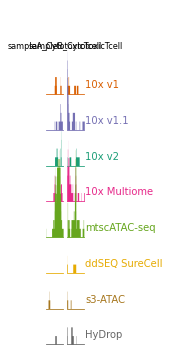

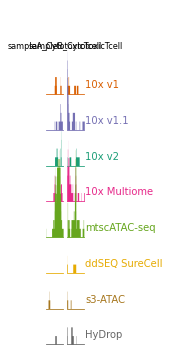

In [86]:
## create the gridspec
fig = plt.figure(figsize=figsize, facecolor="white")

# define ratios between all elements in the graphic
height_ratios = [0.2]  # for gtf
height_ratios.append(len(bw_path_dict_dict))  # for bws
height_ratios.append(0.1)  # for text box

# create a global frame for the 3 modalities shown (bigwigs, gtf, and text)
frame = gridspec.GridSpec(3, 1, wspace=0.25, hspace=0.17, height_ratios=height_ratios)

# create a gridspec for each modality within the frame
n_cols = len(regions_dict)
n_rows = len(tech_order)

text_grid = gridspec.GridSpecFromSubplotSpec(
    1, n_cols, wspace=0.2, hspace=0, subplot_spec=frame[0, 0]
)
bw_dar_grid = gridspec.GridSpecFromSubplotSpec(
    n_rows, n_cols, wspace=0.2, hspace=-0.6, subplot_spec=frame[1, 0]
)
gtf_grid = gridspec.GridSpecFromSubplotSpec(
    max_genes, n_cols, wspace=0.2, hspace=0, subplot_spec=frame[2, 0]
)

## iterate over all regions (=columns in final figure)
for region_name in cell_type_order:
    if verbose == True:
        print(f"drawing column for region {region_name}")
    region_index = cell_type_order.index(
        region_name
    )  # get the region index for column indexing

    # the genome coordinates over which we will be plotting:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])
    x = np.array(range(start, end, 1))

    # set ymax according to region
    # bw_ymax = region_max_dict[region_name]

    # you can also set global ymax:
    bw_ymax = region_max_dict_padded[
        max(region_max_dict_padded, key=region_max_dict_padded.get)
    ]

    ## iterate over all bigwigs (=rows in final figure)
    for key in tech_order:
        if verbose == True:
            print(f"\t{key}: alias {tech_alias_dict[key]}")

        bw_index = tech_order.index(key)  # get the bw index for row indexing

        # create a new gridspec for bw + dar
        if "regions_dict_padded" in locals() or "peak_path_dict" in locals():
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                2,
                1,
                wspace=0.05,
                hspace=0,
                subplot_spec=bw_dar_grid[bw_index, region_index],
                height_ratios=[20, 0.5],
            )
        else:
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                1,
                1,
                wspace=0.05,
                hspace=0.2,
                subplot_spec=bw_dar_grid[bw_index, region_index],
            )

        # open the bigwig
        bw_file = bw_path_dict_dict[region_name][key]
        if verbose == True:
            print(f"\t\tbw: {bw_file}")

        bw = pyBigWig.open(bw_file)
        y = bw.values(chrom, start, end)
        y = np.nan_to_num(y)

        # now plot the bigwig in the gridspec
        ax = plt.Subplot(fig, bw_dar_subgrid[0, 0])
        ax.fill_between(
            x, y1=y, y2=0, step="mid", linewidth=0, color=tech_color_palette[key]
        )
        ax.patch.set_alpha(0)

        # figure settings
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([0, bw_ymax])
        ax.set_xticks([])
        ax.set_yticks([])

        # add a ylabel only if it's the last column
        if region_name == cell_type_order[-1]:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(
                tech_alias_dict[key],
                rotation=0,
                horizontalalignment="left",
                verticalalignment="bottom",
                color=tech_color_palette[key],
            )
            ax.yaxis.set_label_coords(1.05, 0.05)

        # add a title only if it's the first row
        if tech_order.index(key) == 0:
            region = regions_dict_padded[region_name]
            length = round((end - start) / 1000)
            label = f"{cell_type_alias_dict[region_name]}"

            ax.set_title(label, fontsize=8, y=0.45)

        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(tech_color_palette[key])

        # add to the fig
        fig.add_subplot(ax, transparent=True)

        # first draw peaks if they are defined
        if "peak_path_dict" in locals():
            # get peaks that overlap the region to be plotted
            peak = BedTool(peak_path_dict[region_name])
            peak_region_intersection = peak.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            peak_region_intersection = peak_region_intersection.to_dataframe(
                header=None
            )
            peak_region_intersection = peak_region_intersection.iloc[:, :4]
            peak_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in peak_region_intersection.index:
                part = peak_region_intersection.loc[element]
                peak_start = part["start"]
                peak_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([peak_start, peak_end], [0, 0], linewidth=4, c=peak_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

        # then draw dars if they are defined
        if "regions_path_dict" in locals():
            # get DARs that overlap the region to be plotted
            dar = BedTool(regions_path_dict[region_name])
            if verbose == True:
                print(f"\t\tdar: {regions_path_dict[region_name]}")

            dar_region_intersection = dar.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            dar_region_intersection = dar_region_intersection.to_dataframe(header=None)
            dar_region_intersection = dar_region_intersection.iloc[:, :4]
            dar_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in dar_region_intersection.index:
                part = dar_region_intersection.loc[element]
                dar_start = part["start"]
                dar_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([dar_start, dar_end], [0, 0], linewidth=4, c=dar_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

    ## draw the genes of interest, from our gtf
    # intersect genes gtf with the region of interest
    if plot_genes == True:
        gtf = BedTool(gtf_file)
        gtf_region_intersection = gtf.intersect(
            BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
        )
        gtf_region_intersection = gtf_region_intersection.to_dataframe(header=None)
        gtf_region_intersection = gtf_region_intersection.iloc[:, :9]
        gtf_region_intersection.columns = (
            "chr db feature start end score strand frame attribute".split()
        )

        ## iterate over all genes of interest in genes_dict
        for gene in genes_dict[region_name]:
            gene_index = genes_dict[region_name].index(
                gene
            )  # get gene index for row indexing

            # get gtf intersection with only gene body and exons of this particular gene
            gtf_region_intersection_gene = gtf_region_intersection[
                gtf_region_intersection["attribute"].str.contains(gene)
            ]
            gtf_region_intersection_gene = gtf_region_intersection_gene[
                gtf_region_intersection_gene["feature"].str.contains("gene|exon")
            ]

            # now plot the gene parts (gene body and gene exon)
            ax = plt.Subplot(fig, gtf_grid[gene_index, region_index])

            # iterate over all parts to plot them
            for element in gtf_region_intersection_gene.index:
                part = gtf_region_intersection_gene.loc[element]

                # make exons thick
                if part["feature"] == "exon":
                    exon_start = part["start"]
                    exon_end = part["end"]
                    # draw rectangle for exon
                    rect = mpatches.Rectangle(
                        (exon_start, exon_bottom),
                        exon_end - exon_start,
                        exon_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

                # make the gene body a thin line, drawn at the end so it will always display on top
                elif part["feature"] == "gene":
                    gene_start = part["start"]
                    gene_end = part["end"]
                    rect = mpatches.Rectangle(
                        (gene_start, gene_bottom),
                        gene_end - gene_start,
                        gene_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

        if verbose == True:
            print(
                f"\tfor region {region_name}, drew gene {gene}, {len(gtf_region_intersection_gene.index)} individual items drawn\n"
            )

        # figure settings
        ax.set_ylim([exon_bottom, -exon_bottom])
        ax.set_xlabel(gene, fontsize=10)
        addax()

# fig.savefig(
#     "plts_track/dar_best_track__per_tech_harmony_cell_type_bigwigs_nonnorm.png",
#     dpi=350,
#     bbox_inches="tight",
#     pad_inches=0,
#     transparent=False,
#     facecolor="white",
# )
# fig.savefig(
#     "plts_track/dar_best_track__per_tech_harmony_cell_type_bigwigs_nonnorm.svg",
#     dpi=350,
#     bbox_inches="tight",
#     pad_inches=0,
#     transparent=False,
#     facecolor="white",
# )

fig